In [1]:
!pip install -U coremltools
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
import urllib
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import torch
import torch.nn as nn
import torchvision
import json
import os

from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset


import coremltools as ct

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import albumentations as A
from albumentations.pytorch import ToTensorV2
#google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#unet class
class UNet(pl.LightningModule):
    #layers definition
    def __init__(self, in_channels=3, out_channels=1): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        self.in_channels = in_channels
        self.out_channels = out_channels
        #1st downsample layer
        self.conv11 = nn.Conv2d(self.in_channels, 64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        #output layer
        self.outconv = nn.Conv2d(64, self.out_channels, kernel_size=1) #2 classes: portrait and not portrait

        #loss function
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        #encoder forward
        xconv11 = F.relu(self.conv11(x))
        xconv12 = F.relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = F.relu(self.conv21(xpool1))
        xconv22 = F.relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = F.relu(self.conv31(xpool2))
        xconv32 = F.relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = F.relu(self.conv41(xpool3))
        xconv42 = F.relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = F.relu(self.conv51(xpool4))
        xconv52 = F.relu(self.conv52(xconv51))

        #decoder forward
        xup1 = self.upconv1(xconv52)

        #dimension mismatch check:
        if xup1.size() != xconv42.size():
            diffY = xconv42.size()[2] - xup1.size()[2]
            diffX = xconv42.size()[3] - xup1.size()[3]
            xup1 = F.pad(xup1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])

        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = F.relu(self.u11(xu11))
        xd12 = F.relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = F.relu(self.u21(xu22))
        xd22 = F.relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = F.relu(self.u31(xu33))
        xd32 = F.relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = F.relu(self.u41(xu44))
        xd42 = F.relu(self.u42(xd41))

        #output layer
        out = self.outconv(xd42)
        return out

    def training_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs)
      outputs = torch.squeeze(outputs, 1)
      loss = self.loss_fn(outputs, targets)
      self.log('train_loss', loss, logger=True, prog_bar=True, on_epoch=True)
      return loss
    def validation_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs)
      outputs = torch.squeeze(outputs, 1)
      loss = self.loss_fn(outputs, targets)
      self.log('val_loss', loss, logger=True, prog_bar=True, on_epoch=True)
      return loss

    def test_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs)
      outputs = torch.squeeze(outputs, 1)
      loss = self.loss_fn(outputs, targets)
      self.log('test_loss', loss, logger=True, prog_bar=True, on_epoch=True)
          # Visualize a few examples
      if batch_idx < 5:  # Display the first 5 batches
          preds = torch.sigmoid(outputs)
          preds = (preds > 0.5).float()  # Threshold to get binary mask

          # Move tensors to CPU and detach
          inputs_np = inputs.cpu().numpy()
          targets_np = targets.cpu().numpy()
          preds_np = preds.cpu().numpy()

          # Visualize the first image in the batch
          input_image = inputs_np[0].transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
          target_mask = targets_np[0]  # First image, first channel
          pred_mask = preds_np[0]

          # Undo normalization if necessary
          # For example, if you normalized using ImageNet mean and std:
          # mean = np.array([0.485, 0.456, 0.406])
          # std = np.array([0.229, 0.224, 0.225])
          # input_image = (input_image * std) + mean
          # input_image = np.clip(input_image, 0, 1)

          fig, axes = plt.subplots(1, 3, figsize=(15, 5))
          axes[0].imshow(input_image)
          axes[0].set_title('Input Image')
          axes[0].axis('off')

          axes[1].imshow(target_mask, cmap='gray')
          axes[1].set_title('Ground Truth Mask')
          axes[1].axis('off')

          axes[2].imshow(pred_mask, cmap='gray')
          axes[2].set_title('Predicted Mask')
          axes[2].axis('off')

          plt.tight_layout()
          plt.show()
      return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        #lr scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=10, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [4]:
#need val data for purpose of PL trainer object....
!unzip '/content/drive/MyDrive/!personalMLProject/portraitSegmentation/portraitSegData/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: ytrain/13698.png        
  inflating: ytrain/13699.png        
  inflating: ytrain/13700.png        
  inflating: ytrain/13701.png        
  inflating: ytrain/13702.png        
  inflating: ytrain/13703.png        
  inflating: ytrain/13704.png        
  inflating: ytrain/13705.png        
  inflating: ytrain/13706.png        
  inflating: ytrain/13707.png        
  inflating: ytrain/13708.png        
  inflating: ytrain/13709.png        
  inflating: ytrain/13710.png        
  inflating: ytrain/13711.png        
  inflating: ytrain/13712.png        
  inflating: ytrain/13713.png        
  inflating: ytrain/13714.png        
  inflating: ytrain/13715.png        
  inflating: ytrain/13716.png        
  inflating: ytrain/13717.png        
  inflating: ytrain/13718.png        
  inflating: ytrain/13719.png        
  inflating: ytrain/13720.png        
  inflating: ytrain/13721.png        
  inflating: ytrain/13722.png        

In [5]:
#Stuff needed for pytorch lighting to work ):
class portraitSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load images as uint8
        image = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.uint8)

        image = image/255.0
        #print(image)

        # Convert mask to binary values
        mask[mask == 255] = 1

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Should be torch.Tensor
            mask = augmented['mask']    # Should be torch.Tensor

        else:
            # If no transform, convert to tensor
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        # # Ensure image is float32 and scaled properly
        image = image.float()
        mask = mask.float()

        return image, mask



xtest_dir = '/content/xtest'
ytest_dir = '/content/ytest'

#reshape image to 128 128
val_preprocess = A.Compose([
    A.Resize(height=128, width=128),
    ToTensorV2(),
])
test_dataset = portraitSegmentationDataset(image_dir=xtest_dir, mask_dir=ytest_dir, transform=val_preprocess)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [7]:
#wrapper for adding sigmoid layer to unet

class UNet_with_sigmoid_layer(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.activation_layer      = nn.Sigmoid()

    def forward(self, x):
        logits = self.backbone(x)
        return self.activation_layer(logits)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

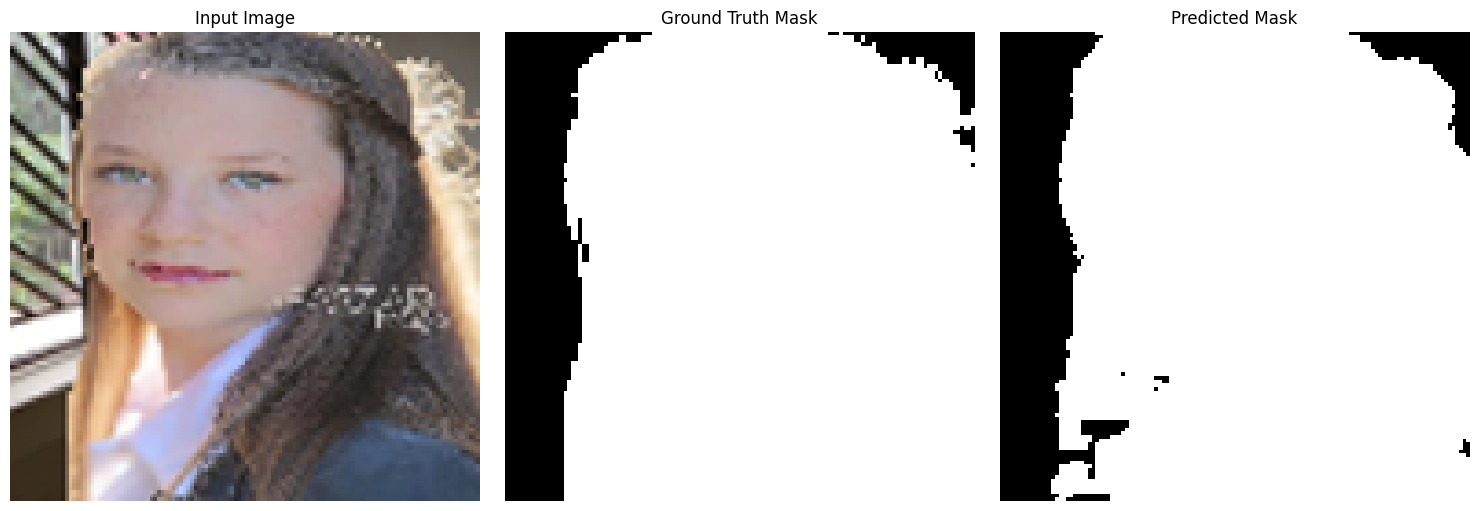

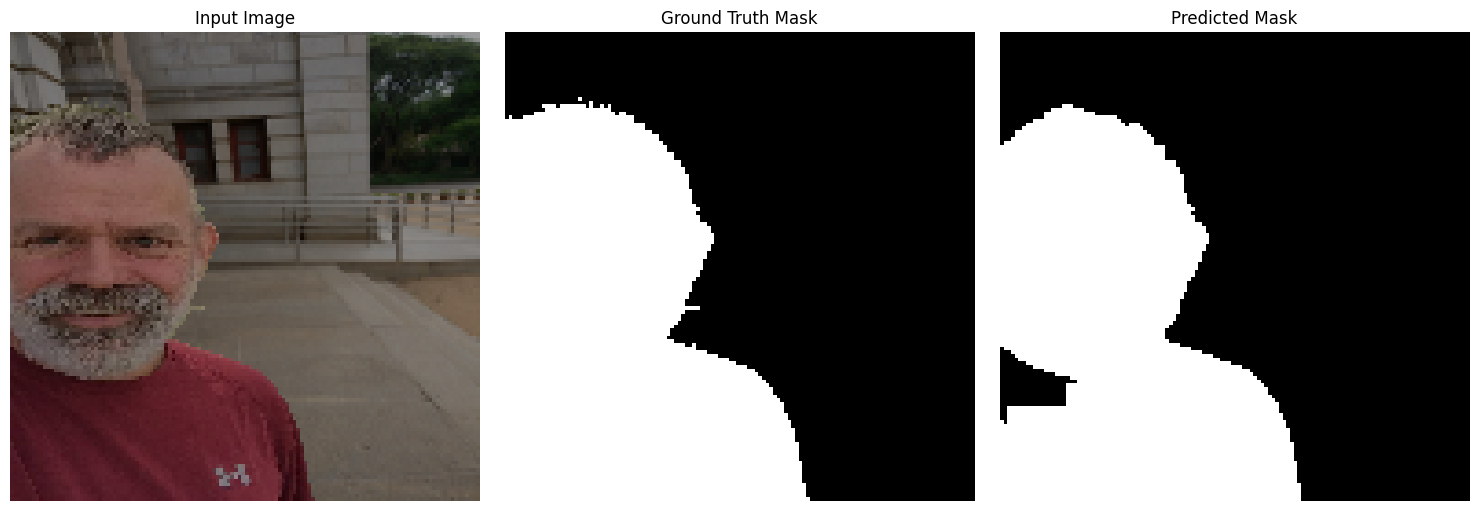

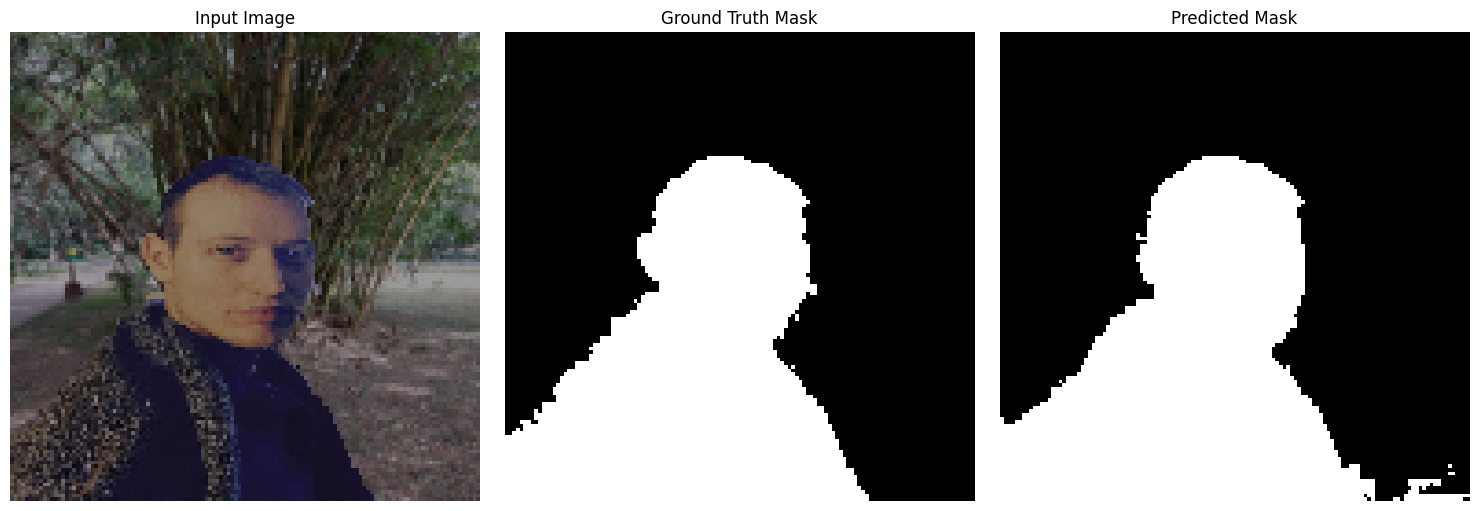

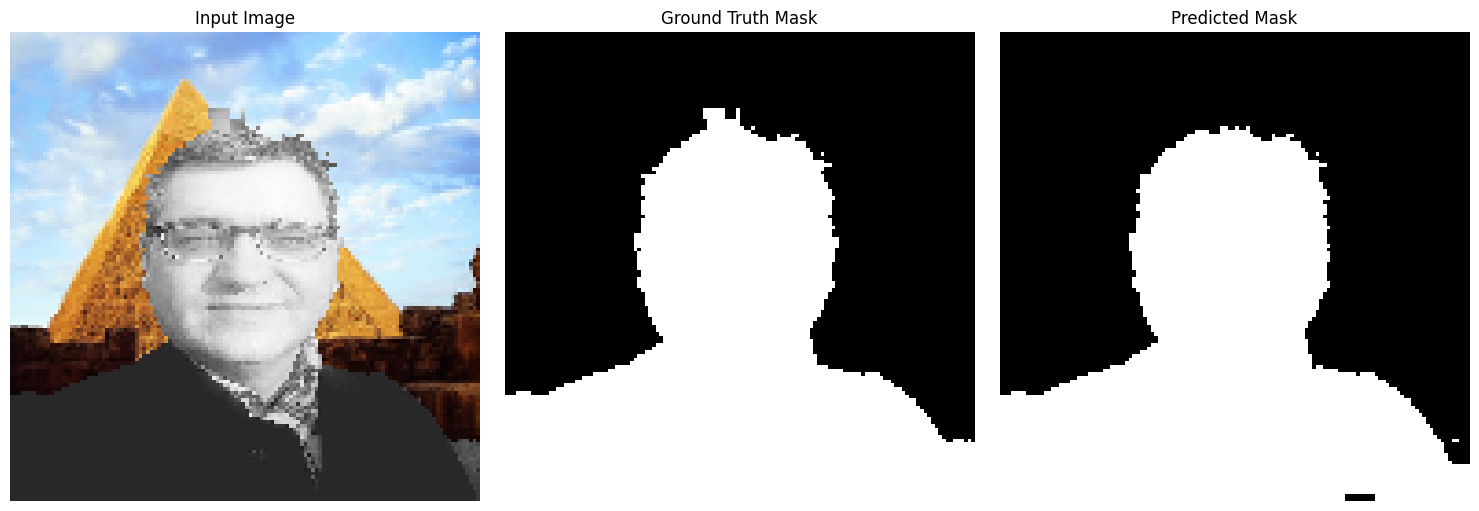

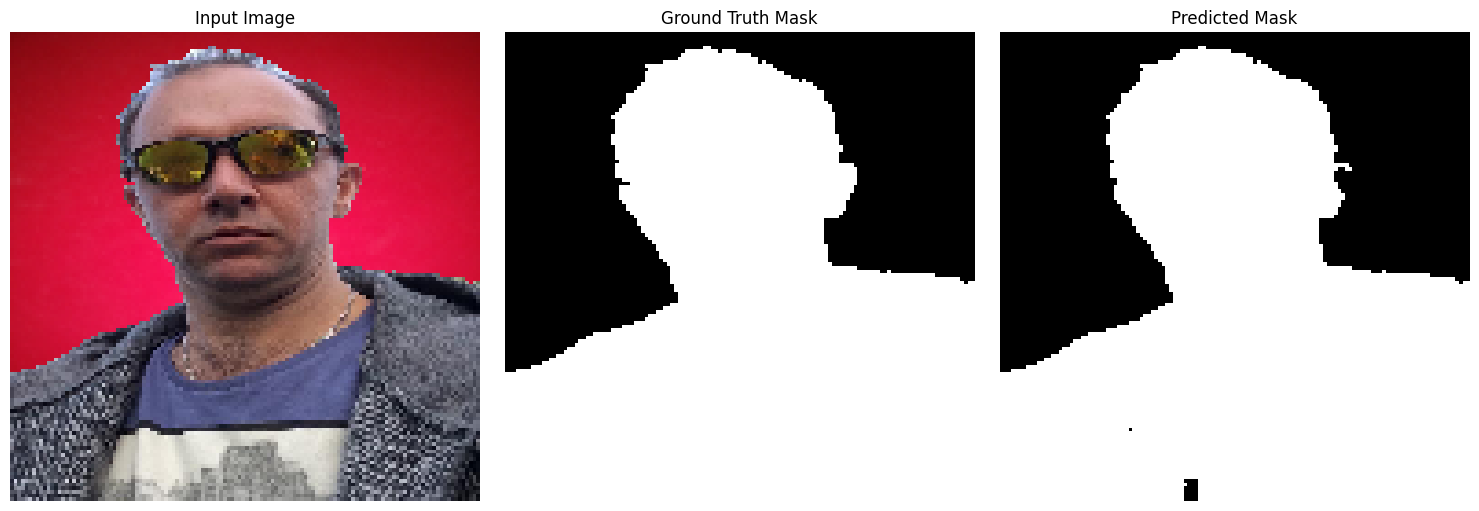

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03957855701446533    │
└───────────────────────────┴───────────────────────────┘

UNet_with_sigmoid_layer(
  (backbone): UNet(
    (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, str

In [15]:
#unet model was trained with pytorch lighting
uNetTest = UNet()
uNetTest.load_state_dict(torch.load('/content/drive/MyDrive/!personalMLProject/portraitSegmentation/uNetModelWeights.pth'))
uNetTest.eval()
#needs the trainer object first
trainer = pl.Trainer()
trainer.test(uNetTest, test_loader)
#wrap with sigmoid layer
uNetTest = UNet_with_sigmoid_layer(uNetTest)
uNetTest.eval()

In [16]:
#trace the model
model_tracer_input = torch.rand(1, 3, 128, 128)
traced_model = torch.jit.trace(uNetTest, model_tracer_input)

<ipython-input-3-846d7a35dc94>:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if xup1.size() != xconv42.size():


In [17]:
#convert using traced model
mlmodel_from_trace = ct.convert(
    traced_model,
    inputs=[ct.TensorType(name="input", shape=model_tracer_input.shape)],
)

Running MIL default pipeline:   0%|          | 0/89 [00:00<?, ? passes/s]/usr/local/lib/python3.11/dist-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '238', of the source model, has been renamed to 'var_238' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 337.33 passes/s]


In [18]:
model_save_path = "/content/drive/MyDrive/!personalMLProject/portraitSegmentation/uNetModelCoreMLMay2025.mlpackage"
mlmodel_from_trace.save(model_save_path)

In [19]:
# load the model, set metadata for xcode preview
mlmodel = ct.models.MLModel(model_save_path)

labels_json = {"labels": ["background", "person"]}

mlmodel.user_defined_metadata["com.apple.coreml.model.preview.type"] = "imageSegmenter"
mlmodel.user_defined_metadata["com.apple.coreml.model.preview.params"] = json.dumps(labels_json)

modelWMetaData_save_path = "/content/drive/MyDrive/!personalMLProject/portraitSegmentation/uNetModelCoreMLMay2025WMetaData.mlpackage"
mlmodel.save(modelWMetaData_save_path)